# Caption 生成に使ったコード

## データ準備

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from nltk.tokenize import sent_tokenize
import re
import os
import datetime
import csv
import copy
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, Dense, LSTM, Reshape, Activation, Embedding, Dense, concatenate, dot, Flatten, Lambda, Add, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm
from keras import backend as K
from keras.applications.xception import Xception, preprocess_input
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from utils.nodeutil import Node

from keras.backend.tensorflow_backend import set_session, get_session

K.clear_session()
config = tf.ConfigProto(
            gpu_options = tf.GPUOptions(
                visible_device_list="3", # specify GPU number
                allow_growth=True)
        )
set_session(tf.Session(config=config))
K.set_image_data_format(data_format='channels_last')

def paths_sorted(paths):
    return sorted(paths, key = lambda x: int(x.name.replace('.txt', '')))

def load_caption_text():

    t_path = Path('emoji/description/detailed/')
    texts = dict()
    used = []
    for filename in list(paths_sorted(t_path.glob("*.txt"))):
        name = int(filename.name.replace('.txt', ''))

        text = filename.read_text(encoding='utf-8').lower().split()
        
        text_ = ''
        for word in text:
            word = word.replace('.', '').replace("'", "").replace('’', '').replace('‘', '').replace(',', '')
            text.append(word)
            # 一度使用された語句を使わない場合
            # 下のブロックの used.append(word) も必要
            # if word in used:
            #    continue
             
            # TF-IDF 上位語のみを使う場合
            #if word in important_words:
                #text_ = text_ + word + ' '
                #used.append(word)
        
        #text = text_

        tokenized = sent_tokenize(text)
        label_number = int(name)
    
        for sentence in tokenized:
            filtered_sentence = re.sub(re.compile("[!-/:-@[-`{-~]"), "", sentence)

            texts[name] = filtered_sentence
    return texts

def tokenize_text(texts, tokenizer = None):
    whole_texts = []
    whole_texts.append("<s> " + texts[key] + " </s>")
        
    if tokenizer == None :
        tokenizer = Tokenizer(filters="")
        tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

def load_data():
    # x_train : please designate the path of NumPy array converted from face photos
    x_train = np.load('facephoto20200119/image.npy', allow_pickle=True)
    
    # キャプション読み込み＆Tokenizerによる数値化
    texts = load_caption_text()
    y_train, tokenizer = tokenize_text(texts)
    vocab_size = len(tokenizer.word_index) + 1
    
    y_train_ = np.empty(shape=(len(y_train), ), dtype=object)
    for i, token_array in enumerate(y_train):
        y_train_[i] = list(token_array)
    
    y_train = y_train_

    # パディング
    y_train = pad_sequences(y_train, padding='post')
    caption_len = len(y_train[0])

    print('caption len: ', caption_len)
    print('vocab_size: ', vocab_size)
    
    return (x_train, y_train, tokenizer)

In [ ]:
load_caption_text()

In [ ]:
x_train, y_train, tokenizer = load_data()

## encoder
- decoder につなげて End to End で学習をさせず、CNN（Xception）であらかじめ特徴量を抽出し、それを decoder に入力する形をとる

In [ ]:
# pretrained model
encoder_input = Input(shape=(299, 299, 3))
#encoder_input_normalized = Lambda(lambda x: x / 255.)(encoder_input) # [0, 255) -> [0, 1)
encoder = Xception(weights='imagenet', include_top=False, input_tensor=encoder_input)

# パラメータを固定
for layer in encoder.layers:
    layer.trainable = False

# CNNの出力
u = Flatten()(encoder.output)

vgg_model = Model(encoder_input, u)

# VGGから特徴量を抽出
x_train_features = []

for x in tqdm(x_train):
    x_features = vgg_model.predict(x[np.newaxis]).flatten()
    x_train_features.append(x_features)

x_train_features = np.stack(x_train_features, axis=0)

# 特徴量を保存
np.save('facephoto20200119/x_train_features_xception', x_train_features)

In [ ]:
# 特徴量の読み込み
x_train_features = np.load('./facephoto20200119/x_train_features_xception.npy')

In [ ]:
encoder.summary()

## decoder

In [ ]:
from keras.layers import Dense, Embedding, LSTM
from keras import backend as K
from keras.layers import Input, Flatten, Lambda

emb_dim = 1024 #1024
hid_dim = 512 #1024
att_dim = 128 #2048
caption_len = 19 # hard code
vocab_size = 394 # hard code

# Encoderの出力
u = Input(shape=(204800,)) # encoder の出力（特徴量の次元）に合わせる

# LSTMの初期状態
decoded_states = [Dense(hid_dim)(u), Dense(hid_dim)(u)] # h_0, c_0 に対応

# 層の定義
decoder_input = Input(shape=(caption_len,))
embedding = Embedding(vocab_size, emb_dim, mask_zero=True)
lstm = LSTM(hid_dim, activation='tanh', return_sequences=True, return_state=True,  dropout=0.7, recurrent_dropout=0.7)

# 層の接続
decoder_embedded = embedding(decoder_input)
decoder_output, _, _ = lstm(decoder_embedded, initial_state=decoded_states) # 第2,3戻り値(最終ステップのh, c)は無視

## attention

In [ ]:
from keras.layers import Reshape, Activation, concatenate, dot

# 0. reshape: (10, 10, 512) -> (100, 512)
u_map = Reshape((32*32, 200))(u) # これもいけるの？

# 1. スコアの計算
dense_att = Dense(hid_dim)
score = dot([decoder_output, dense_att(u_map)], axes=-1)

# 2. 重みの計算
attention = Activation('softmax')(score)

# 3. 文脈ベクトルの計算
context = dot([attention, u_map], axes=(2,1))

# 4. 出力ベクトルの計算
attention_dense = Dense(att_dim, activation='tanh')
output_dense = Dense(vocab_size, activation='softmax')
concat = concatenate([context, decoder_output], axis=2)
attentional = attention_dense(concat)
y_pred = output_dense(attentional)

In [ ]:
from keras.models import Model
from keras.optimizers import Adam, RMSprop

model = Model([u, decoder_input], y_pred)
model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(lr=1e-3))

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

savePath = os.path.join('./facephoto20200119/log/','model_xception.h5')

callbacks = [
    # val_lossが下がらなくなった際に学習を終了するコールバック
    EarlyStopping(monitor='val_loss', patience=20, verbose=1),
    # val_lossが下がらなくなった際に学習率を下げるコールバック
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-9),
    # val_accが最大のmodelを保存するコールバック
    ModelCheckpoint(savePath, monitor='val_acc', save_best_only=True)
]

train_target = np.hstack((y_train[:, 1:], np.zeros((len(y_train),1), dtype=np.int32)))

model.fit([x_train_features, y_train], np.expand_dims(train_target, -1), batch_size=78, 
          epochs=30, verbose=1, callbacks=callbacks)

In [ ]:
model.save('./facephoto20200119/log/model_xception_tosave.h5', include_optimizer=False)

In [ ]:
from keras.models import load_model
model = load_model('./facephoto20200119/log/model_xception_tosave.h5', compile=False)

In [ ]:
# 画像の特徴量からDecoder (LSTM) の初期状態を決めるネットワーク
initial_state_model = Model(u, decoded_states)

# 復号化器
decoder_states_inputs = [Input(shape=(hid_dim,)), Input(shape=(hid_dim,))]

decoder_input = Input(shape=(1,))
decoder_embeded = embedding(decoder_input)
decoded_seq, *decoder_states = lstm(decoder_embeded, initial_state=decoder_states_inputs)
decoder_model = Model([decoder_input] + decoder_states_inputs, [decoded_seq] + decoder_states)

# Attention
u_map_in, decoded_seq_in = Input(shape=(32*32, 200)), Input(shape=(1, hid_dim))
score = dot([decoded_seq_in, dense_att(u_map_in)], axes=-1)
attention = Activation('softmax')(score)
context = dot([attention, u_map_in], axes=(2,1))
concat = concatenate([context, decoded_seq_in], axis=2)
attentional = attention_dense(concat)
attention_outputs = output_dense(attentional)

attention_model = Model([u_map_in, decoded_seq_in], [attention_outputs, attention])

## Beam Search

In [ ]:
# logの中身が0になるのを防ぐ
def np_log(x):
    return np.log(np.clip(x, 1e-10, x))

import sys
sys.path.append('./facephoto20200119/log/') # 検証用
# sys.path.append('/root/userspace/public/lesson5/master/')

import copy

def beam_search(input_features, bos_eos, K=5, max_output_length = 40):
    # LSTMの初期状態を取得
    states = initial_state_model.predict(input_features)
    
    u_map = input_features.reshape(-1, 32*32, 200)
    
    # 上位K個の候補を保存するlist. listの各要素は [候補のスコア (累積の対数尤度), 出力された系列, アテンションの重み, 前時刻での隠れ層・セルの状態] を保持する
    candidates = [[0, np.array(bos_eos[0]), np.empty((0, 32*32)), states]]
    
    # 可視化用のnode
    root = Node(bos_eos[0][0])
    
    # max_output_lengthに到達するまでdecoding
    t = 0
    while t < max_output_length:
        t += 1
        
        # すべての候補を一時的に保管するリスト
        tmp_candidates = []
        
        # </s>がすべての候補で出力されたかどうかのフラッグ
        end_flag = True
        
        # K個の候補に対して新しい候補をそれぞれ生成する
        for score_sum, y_pred, attention_seq, states_prev in candidates:
            
            attention_seq = copy.deepcopy(attention_seq)
            if len(y_pred) > 2:
                if y_pred[-1] == y_pred[-2]:
                    continue
            
            # 前時刻で出力された単語が終端記号</s>だった場合は出力を停止し, そのまま借りの候補に保存する
            if y_pred[-1] == bos_eos[1]:
                tmp_candidates.append([score_sum, y_pred, attention_seq, states_prev])
            else:
                end_flag = False
                
                decoded_seq, *states = decoder_model.predict([y_pred[-1:]] + states_prev)
                token_dist, attention = attention_model.predict([u_map, decoded_seq])
                
                # 確率の高い単語（＝対数尤度の高い単語）とそのidを取得（上位K個）
                y_loglikelihood = np_log(token_dist.flatten())
                y_t, s_t = np.argsort(y_loglikelihood)[::-1][:K], np.sort(y_loglikelihood)[::-1][:K] # argsortは昇順なので反転
                 
                # スコア (対数尤度) を蓄積（s_core_tm1はスカラー, s_tはベクトル）
                s_t = s_t + score_sum
                
                # すべての候補を一時的に保管
                tmp_candidates.extend(
                    [[s_tk, np.append(y_pred, [y_tk]), np.append(attention_seq, [attention.flatten()], axis=0), states] for s_tk, y_tk in zip(s_t, y_t)]
                )
        
        # K個の候補すべてで終端記号</s>が出力されていた場合はloopを抜ける
        if end_flag:
            break
        
        # 正規化したスコア (対数尤度) で降順にソートし, 上位K個の候補を保存
        candidates = sorted(tmp_candidates, key=lambda x: x[0]/len(x[1]), reverse=True)[:K]
        
        # Beam Search可視化用
        root.depth += 1
        for _, y_pred, _, _ in candidates:
            root.add_child(y_pred)
    
    # 最もスコアの高い候補を返す
    return candidates[0][1], root, candidates[0][2]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

bos_eos = tokenizer.texts_to_sequences(["<s>", "</s>"])
detokenizer = dict(map(reversed, tokenizer.word_index.items()))

data_index = -1

x_test_features = x_train_features[data_index]
x_test = x_train[data_index]
y_test = y_train[data_index]

y_pred, root, att_a = beam_search(x_test_features[np.newaxis], bos_eos, K=10, max_output_length=10)

detokenizer[0] = ""

print('生成文:', ' '.join([detokenizer[i] for i in y_pred[1:-1]]))
print('正解文:', ' '.join([detokenizer[i] for i in y_test[1:-1]]))

#plt.imshow(x_test)

#plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from PIL import Image
import numpy as np

pathstr = 'photo/'
for i, org_img in enumerate(sorted(Path(pathstr).glob('*.jpeg'))):
    img = Image.open(str(org_img))
    img = img.convert('RGB').resize((299, 299))
    img_np = np.array(img)
    img_np = (img_np / 127.5) - 1
    y_pred, root, att_a = beam_search(x_test_features[np.newaxis], bos_eos, K=10, max_output_length=15)
    detokenizer[0] = ""
    print('生成文:', ' '.join([detokenizer[i] for i in y_pred[1:-1]]))

## attention の可視化

In [ ]:
import skimage.transform

fig = plt.figure(figsize=(18, 10))

for i, (wordid, att_a_t) in enumerate(zip(y_pred[1:-1], att_a)):
    ax = fig.add_subplot(5, 5, i+1)
    
    # Plot image
    ax.imshow(x_test)
    ax.axis('off')
    
    # Plot attention
    att_a_t = skimage.transform.pyramid_expand(att_a_t.reshape(32, 32), upscale=32, sigma=20)
    ax.imshow(att_a_t, alpha=.50)
    # Plot word
    ax.set_title(detokenizer[wordid])

plt.show()

In [ ]:
plt.close('all')

## 参考（使用したテキスト）

In [20]:
load_caption_text()

{0: ' face with scrunched up and closed eyes frowning',
 1: ' a person with a surgical mask on their face generally used in a hospital setting or when working with dangerous fumes',
 2: ' a face with the mouth wide open which is generally used to represent an element of surprise',
 3: ' a sad face with tears streaming down both cheeks',
 4: ' this emoji has eyes and no mouth',
 5: ' a sad face with a single tear running from one eye down the cheek',
 6: ' face with eyes closed and a sleep symbol – zzz – over the head',
 7: ' an angry looking face',
 8: ' a face that looks more surprised than hushed it has high eyebrows and an open mouth',
 9: ' a yellow face with a slight partially open smile and its left eye winking right on whatsapp',
 10: ' a pouting face outwardly showing displeasure with a person or situation',
 11: ' a dizzy face looking sick or confused from being spun around in circles too many times',
 12: ' this emoji is kissing but also looks like a whistling emoji or blowin

----
## tf-idf 処理に使ったコード
- 各絵文字に共通して現れる言い回しや stop words の類の影響を軽減する方針

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.0)
X = vectorizer.fit_transform(texts).toarray()

index = X.argsort(axis=1)[:,::-1]
feature_names = np.array(vectorizer.get_feature_names())
feature_words = feature_names[index]

In [ ]:
import pandas as pd
feature_words = pd.DataFrame(feature_words)

In [ ]:
X_df = pd.DataFrame(X)
important = X_df.sum(axis=0).sort_values(ascending=False)[:400]
important

In [ ]:
index = important.keys()
feature_names = np.array(vectorizer.get_feature_names())
important_words = feature_names[index]

In [ ]:
important_words =  list(important_words)

In [84]:
feature_words

,0,1,2,3,4,5,6,7,8,9,...,627,628,629,630,631,632,633,634,635,636
0,persevering,helplessness,verge,scrunched,show,up,frowning,tears,closed,situation,...,relieved,relief,regular,referred,red,raising,raised,radiant,quizzical,2010s
1,mask,seen,surgical,public,disease,working,fumes,primarily,medical,asia,...,relief,regular,referred,red,raising,raised,radiant,quizzical,quivering,2010s
2,pouting,mad,emotions,furrowed,displeasure,outwardly,angry,brow,commonly,most,...,representing,represent,remorseful,relieved,relief,regular,referred,red,raising,2010s
3,dizzy,times,spun,circles,too,many,sick,around,being,looking,...,relieved,relief,regular,referred,red,raising,raised,radiant,quizzical,2010s
4,kissing,music,whistling,whistle,anything,innocent,pretending,do,combined,especially,...,represent,remorseful,relieved,relief,regular,referred,red,raising,raised,2010s
5,grimacing,eek,unfavorable,bared,grimace,arisen,mistake,aka,when,teeth,...,relief,regular,referred,red,raising,raised,radiant,quizzical,quivering,2010s
6,fear,screaming,holding,jaw,two,hands,cheeks,are,wide,shown,...,relieved,relief,regular,referred,red,raising,raised,radiant,quizzical,2010s
7,stressful,relieved,brow,dripping,due,sweat,its,from,sad,situation,...,regular,referred,red,raising,raised,radiant,quizzical,quivering,quietly,2010s
8,nose,yet,disdainful,huff,steam,frustration,way,representing,coming,proud,...,relieved,relief,regular,referred,red,raising,raised,radiant,quizzical,2010s
9,sweat,concern,anxious,blue,forehead,cheek,look,dripping,down,and,...,represent,remorseful,relieved,relief,regular,referred,red,raising,raised,2010s


In [ ]:
# feature words 上位 5 語のみ取得
k = 5
feature_words.loc[:,:5].values

In [ ]:
#texts = load_caption_text()
enc_result = glove_model.encode_docs(texts)

In [71]:
x_train.shape

(78, 299, 299, 3)

### PCA を用いた取組みに使ったコード

In [15]:
import numpy as np

cap_emb = np.load('encoded_caption_of_emojis_200120.npy') # GloVe で各絵文字の説明文を 300 次元のベクトルとしたもの

In [ ]:
from sklearn.decomposition import PCA

del pca
# n_componentsに目標とする累積寄与率を指定
pca = PCA(n_components = 0.95)
# fit_transformで主成分分析を行い、さらにデータを写像
cap_emb_pca = pca.fit_transform(cap_emb)
# components_に主成分ベクトルが保存される
pca.components_

In [ ]:
# PCA で次元削減したものを300次元に戻す
cap_emb_re = pca.inverse_transform(cap_emb_pca)

### 生成された絵文字の可視化

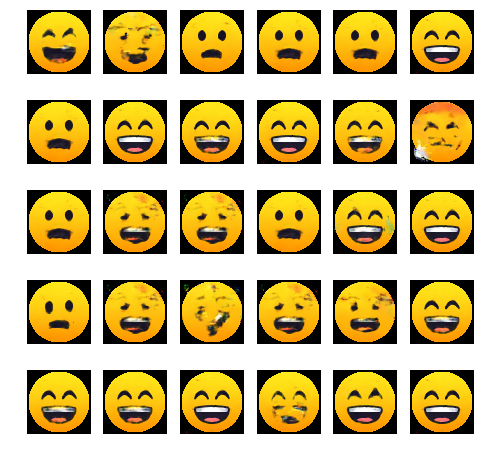

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from PIL import Image
import numpy as np

fig, ax = plt.subplots(5, 6, figsize=(8, 8))
pathstr = 'images/fromphoto200120/old/captioner/'
for i, org_img in enumerate(sorted(Path(pathstr).glob('*.png'))):
    img = Image.open(str(org_img))
    img.convert('RGBA')
    ax[int((i - (i %6))/6)][(i%6)].imshow(np.array(img))
    ax[int((i - (i %6))/6)][(i%6)].axis('off')